In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.optim import AdamW
import math 
import matplotlib.pyplot as plt

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
%load_ext autoreload
%autoreload 2

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

/mnt/ssd3/user/spock/.cache/pypoetry/virtualenvs/ai-iwSNfyWa-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# token_transform

In [4]:
# next(iter(Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))))

In [5]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [6]:
from torch.nn.utils.rnn import pad_sequence
from torchtext.transforms import PadTransform, Truncate, AddToken, VocabTransform, Sequential, ToTensor

class Tokenize(nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        
    def forward(self, x):
        # Do some transformations
        return [self.tokenizer(sentence) for sentence in x]

class Pad(nn.Module):
    def __init__(self, length, pad_value):
        super().__init__()
        self.length = length
        self.pad_value = pad_value 

    def forward(self, x):
        # m = max(len(x_) for x_ in x)
        def pad(x):        
            if len(x) < self.length:
                x += [self.pad_value] * (self.length - len(x))
            return x
            
        return [pad(x_) for x_ in x]

def get_preproc(token_transform, vocab_transform, max_seq_len):
    # vocab = 
    return nn.Sequential(
        Tokenize(token_transform),
        VocabTransform(vocab_transform),
        Truncate(max_seq_len=max_seq_len-2),
        AddToken(BOS_IDX, begin=True),
        AddToken(EOS_IDX, begin=False),
        Pad(pad_value=PAD_IDX,length=max_seq_len),
        ToTensor(),
    )

BLOCK_SIZE=24
preproc_src = get_preproc(token_transform['de'],vocab_transform['de'], max_seq_len=BLOCK_SIZE)
# can remove this +1 since last token is basically EOS
preproc_tgt = get_preproc(token_transform['en'],vocab_transform['en'], max_seq_len=BLOCK_SIZE+1)
preproc_tgt(['hello', 'my fellow'])

tensor([[   2, 5465,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1],
        [   2, 2227, 2572,    3,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1]])

In [7]:
BATCH_SIZE=256
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE)
test_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE)

In [8]:
# from ai.models.nlp.seq2seq.simple_attention import Encoder, Decoder
from ai.models.nlp.seq2seq.bahdana import EncoderRNN, AttnDecoderRNN
device = torch.device('cuda')

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
n_embd=32
encoder = EncoderRNN(input_size=SRC_VOCAB_SIZE, hidden_size=n_embd).to(device)
decoder = AttnDecoderRNN(output_size=TGT_VOCAB_SIZE, hidden_size=n_embd, block_size=BLOCK_SIZE, BOS_token=BOS_IDX).to(device)

In [9]:
lr=.003
optim1 = AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

In [18]:
step = 0
for epoch in range(10):
    for src,tgt in train_dataloader:
        step +=1
        src = preproc_src(src).to(device)
        tgt = preproc_tgt(tgt).to(device)
        
        enc_outputs, enc_hidden = encoder(src)
        decoder_outputs, decoder_hidden, attentions = decoder(enc_outputs, enc_hidden, tgt)
        loss = F.cross_entropy(decoder_outputs.view(-1, decoder_outputs.shape[-1]), tgt[:,1:].contiguous().view(-1))
        if step % 100 == 0:
            print(f'e{epoch}:s{step} | loss:{loss:.3f}')
        optim1.zero_grad()
        # optim2.zero_grad()
        loss.backward()
        optim1.step()
        # optim2.step()
        # break


/mnt/ssd3/user/spock/.cache/pypoetry/virtualenvs/ai-iwSNfyWa-py3.10/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


e0:s100 | loss:2.897


/mnt/ssd3/user/spock/.cache/pypoetry/virtualenvs/ai-iwSNfyWa-py3.10/lib/python3.10/site-packages/torch/_jit_internal.py:1358: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(


e1:s200 | loss:2.500
e2:s300 | loss:2.454
e3:s400 | loss:2.333
e4:s500 | loss:2.142
e5:s600 | loss:2.166
e6:s700 | loss:2.226
e7:s800 | loss:2.192
e7:s900 | loss:2.638
e8:s1000 | loss:2.126
e9:s1100 | loss:2.192


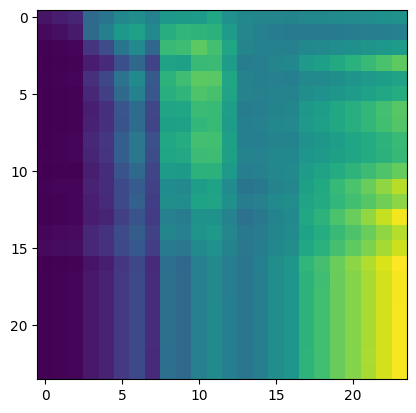

In [13]:
plt.imshow(attentions[0].detach().cpu().numpy())

In [14]:
# y_hat[:,:-1]

In [15]:
itos=vocab_transform['en'].get_itos()
stoi=vocab_transform['en'].get_stoi()

for X,y in test_dataloader:
    break
X = preproc_src(X).to(device)
y = preproc_tgt(y).to(device)

y_hat = torch.tensor([[BOS_IDX] + [PAD_IDX]*(BLOCK_SIZE) for _ in range(y.shape[0])]).to(device)
for i in range(0,BLOCK_SIZE):
    enc_outputs, enc_hidden  = encoder(X)
    decoder_outputs, decoder_hidden, attentions = decoder(enc_outputs, enc_hidden, tgt)
    y_hat[:, i+1] = decoder_outputs[:, i].topk(1).indices.flatten()

for i in range(X.shape[0]):
    print('src :'+' '.join(vocab_transform['de'].lookup_tokens(X[i].tolist())).replace('<pad>',''))
    print('yhat:'+' '.join(vocab_transform['en'].lookup_tokens(y_hat[i].tolist())).replace('<pad>',''))    
    print('y   :'+' '.join(vocab_transform['en'].lookup_tokens(y[i].tolist())).replace('<pad>',''))    
    print('*'*72)
    if i>10:
        break
        

src :<bos> Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen <eos>             
yhat:<bos> A group of in man in a a a . . <eos> . . <eos>         
y   :<bos> A group of men are loading cotton onto a truck <eos>             
************************************************************************
src :<bos> Ein Mann schläft in einem grünen Raum auf einem Sofa . <eos>           
yhat:<bos> A man in in a a in is a a in in is a a . . . <eos> . . <eos>  
y   :<bos> A man sleeping in a green room on a couch . <eos>            
************************************************************************
src :<bos> Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau . <eos>           
yhat:<bos> A man a a a in a of . <eos> <eos>             
y   :<bos> A boy wearing headphones sits on a woman 's shoulders . <eos>            
************************************************************************
src :<bos> Zwei Männer bauen eine blaue <unk> auf einem <unk> See auf <eos>          

In [16]:
import matplotlib.pyplot as plt
attentions[0].detach().cpu().numpy()

array([[0.00395802, 0.0032268 , 0.02412406, 0.03925501, 0.04424185,
        0.04538531, 0.04907579, 0.05042267, 0.06135575, 0.05149632,
        0.05189437, 0.04620714, 0.04388232, 0.04322834, 0.04277337,
        0.04273958, 0.04247819, 0.04274226, 0.04336159, 0.04392469,
        0.04484616, 0.04579854, 0.04645703, 0.04712481],
       [0.00158947, 0.00123582, 0.02107078, 0.04057724, 0.04638335,
        0.05052602, 0.05296296, 0.05435207, 0.06553932, 0.05519526,
        0.05759432, 0.0488828 , 0.04530928, 0.04393069, 0.04277008,
        0.04207005, 0.04105425, 0.04067236, 0.04067171, 0.04073029,
        0.04111985, 0.04160422, 0.04188425, 0.04227357],
       [0.00049723, 0.0003868 , 0.0045074 , 0.01597761, 0.02399592,
        0.03458279, 0.049248  , 0.05781901, 0.08755057, 0.06368084,
        0.07079025, 0.053028  , 0.0471844 , 0.04560588, 0.04424614,
        0.04376028, 0.04266825, 0.04255125, 0.04307365, 0.04357846,
        0.04472345, 0.04598508, 0.0467878 , 0.04777089],
       [0.000

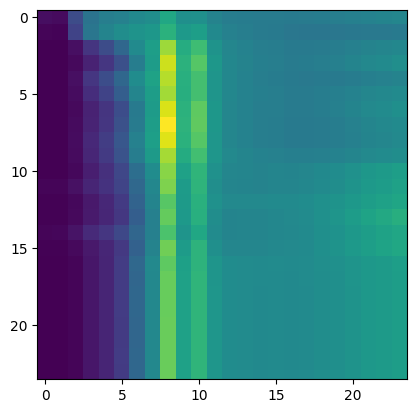

In [17]:
import matplotlib.pyplot as plt
plt.imshow(attentions[0].detach().cpu().numpy())